In [6]:
using ModelingToolkit
t = ModelingToolkit.t_nounits
D = ModelingToolkit.D_nounits

Differential(t)

In [7]:
@parameters h_c m₀ h₀ g₀ D_c c Tₘ m_c
@variables begin
    h(..)
    v(..)
    m(..), [bounds = (m_c, 1)]
    T(..), [input = true, bounds = (0, Tₘ)]
end

drag(h, v) = D_c * v^2 * exp(-h_c * (h - h₀) / h₀)
gravity(h) = g₀ * (h₀ / h)

eqs = [D(h(t)) ~ v(t),
    D(v(t)) ~ (T(t) - drag(h(t), v(t))) / m(t) - gravity(h(t)),
    D(m(t)) ~ -T(t) / c]

(ts, te) = (0.0, 0.2)
costs = [-h(te)]
cons = [T(te) ~ 0, m(te) ~ m_c]

@named rocket = System(eqs, t; costs, constraints=cons)
rocket = mtkcompile(rocket, inputs=[T(t)])

u0map = [h(t) => h₀, m(t) => m₀, v(t) => 0]
pmap = [
    g₀ => 1, m₀ => 1.0, h_c => 500, c => 0.5 * √(g₀ * h₀), D_c => 0.5 * 620 * m₀ / g₀,
    Tₘ => 3.5 * g₀ * m₀, T(t) => 0.0, h₀ => 1, m_c => 0.6]

LoadError: LoadError: UndefVarError: `@variables` not defined in `Main`
Hint: It looks like two or more modules export different bindings with this name, resulting in ambiguity. Try explicitly importing it from a particular module, or qualifying the name with the module it should come from.
Hint: a global variable of this name also exists in JuMP.
    - Also exported by InfiniteOpt.
Hint: a global variable of this name also exists in Symbolics.
    - Also exported by ModelingToolkit.
in expression starting at In[7]:2

In [ ]:
using InfiniteOpt, Ipopt, DiffEqDevTools
jprob = JuMPDynamicOptProblem(rocket, [u0map; pmap], (ts, te); dt=0.001)
jsol = solve(jprob, JuMPCollocation(Ipopt.Optimizer, constructRadauIIA5()));

[ Info: Precompiling InfiniteOpt [20393b10-9daf-11e9-18c9-8db751c92c57] 

SYSTEM: caught exception of type :MethodError while trying to print a failed Task notice; giving up
ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
┌ Info: Skipping precompilation due to precompilable error. Importing InfiniteOpt [20393b10-9daf-11e9-18c9-8db751c92c57].
└   exception = Error when precompiling module, potentially caused by a __precompile__(false) declaration in the module.
[ Info: Precompiling MTKInfiniteOptExt [7d23a930-ffc6-5218-b281-0abae0d3bc6f] 

SYSTEM: caught exception of type :MethodError while trying to print a failed Task notice; giving up
┌ Warning: Module InfiniteOpt with build ID ffffffff-ffff-ffff-11bf-778742fb0208 is missing from the cache.
│ This may mean InfiniteOpt [20393b10-9daf-11e9-18c9-8db751c92c57] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:2613
┌


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



┌ Warning: The control problem is overdetermined. The total number of conditions (# constraints + # fixed initial values given by op) exceeds the total number of states. The solvers will default to doing a nonlinear least-squares optimization.
└ @ ModelingToolkit ~/.julia/packages/ModelingToolkit/b28X4/src/systems/optimal_control_interface.jl:99


In [ ]:
using CairoMakie

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie ~/.julia/packages/Makie/4JW9B/src/scenes.jl:264


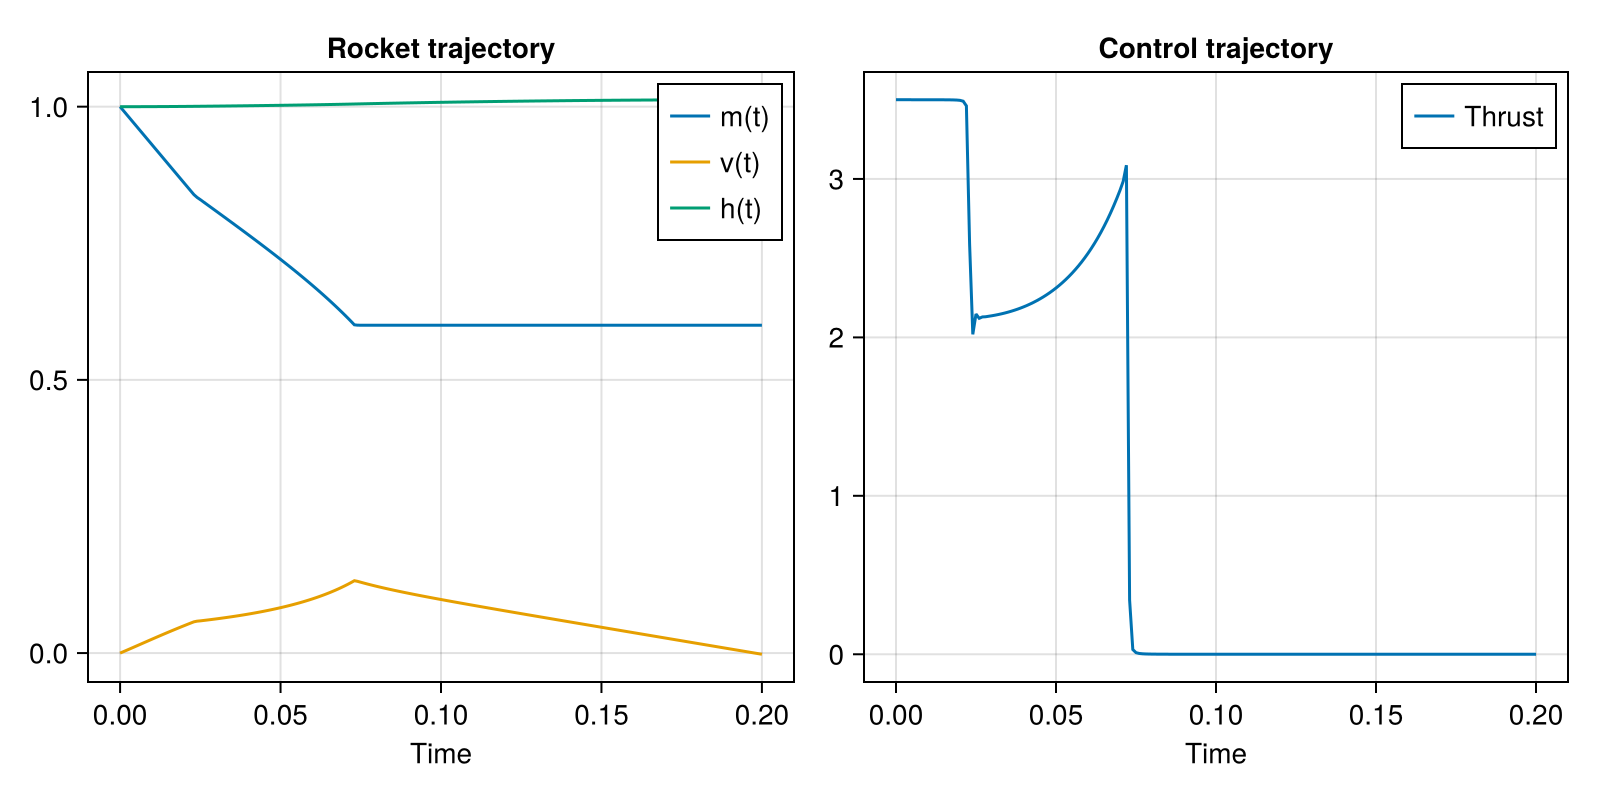

In [ ]:
fig = Figure(resolution=(800, 400))
ax1 = Axis(fig[1, 1], title="Rocket trajectory", xlabel="Time")
ax2 = Axis(fig[1, 2], title="Control trajectory", xlabel="Time")

for u in unknowns(rocket)
    lines!(ax1, jsol.sol.t, jsol.sol[u], label=string(u))
end
lines!(ax2, jsol.input_sol, label="Thrust")
axislegend(ax1)
axislegend(ax2)
fig